## AutoEncoder의 등장

## Manifold learning

AE 의 특징 중 가장 중요한 것은 Manifold learning을 통한 차원축소이다.  
데이터가 고차원일수록 시간복잡도 및 공간복잡도가 늘어나고,  
고차원 데이터로 학습된 모델은 내부 파라미터가 복잡하여 과적합될 수 있기 때문에 차원 축소는 중요한 역할을 한다.  

AE 는 Manifold 를 잘 학습하여 차원축소를 할 수 있다.  
Manifold 란 고차원의 데이터를 점의 형태로 표현했을 때, 그 점들을 error 없이 아우르는 subspace를 말한다.  



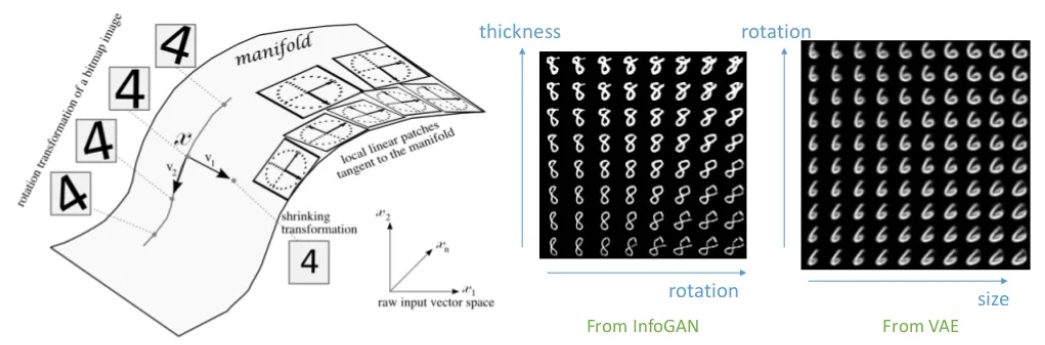

MNIST의 손글씨 데이터로 예를 들면 28*28=784 차원의 공간에서 Manifold 를 잘 찾는다면 글씨의 회전,두께 등의 특징을 알아서 잘 찾을 수 있다.

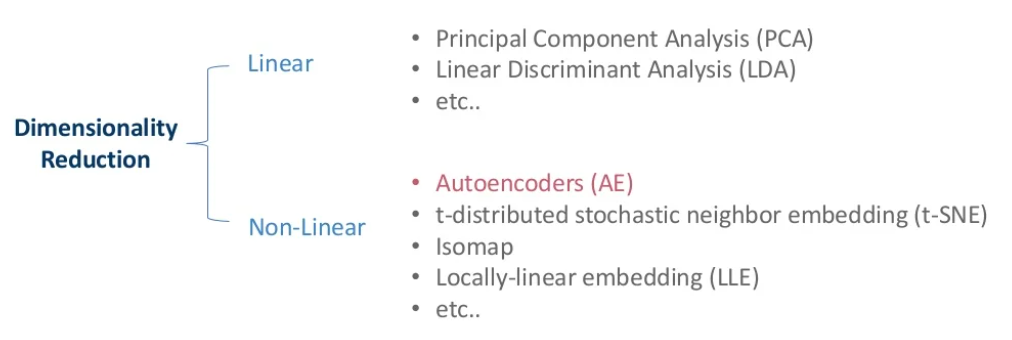

차원 축소 방법은 AE 이외에도 여러개가 존재한다.  
크게 Linear한 방법과 Non-Linear한 방법으로 나눌 수 있다.

### PCA (principal component analysis)

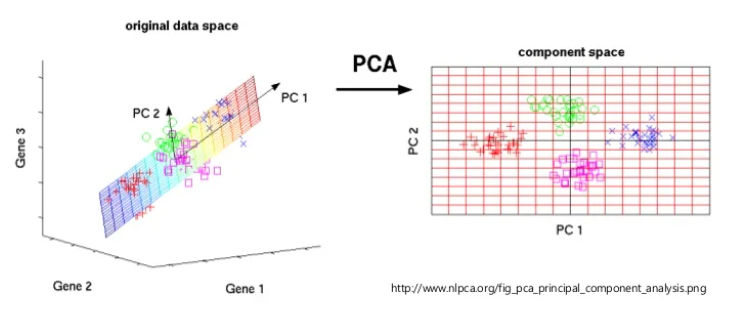

주성분 분석은 고차원의 데이터를 저차원의 데이터로 바꿔 준다.  
이때 정보의 손실을 최소화 하기 위해 분산을 최대로 하는 축을 찾는다.

### LDA (linear discriminant analysis)

https://hyunsooworld.tistory.com/entry/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94Autoencoder%EA%B0%80-%EB%AD%90%EC%97%90%EC%9A%94-2Why-AutoEncoder?category=999000

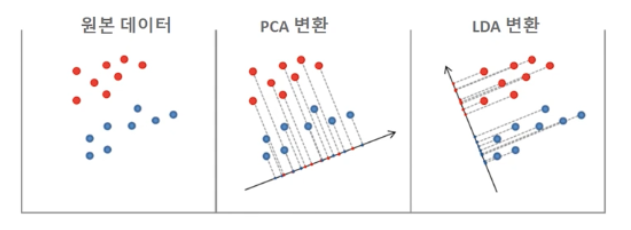

LDA는 PCA와 유사하며 분류에 더 최적화된 차원 축소 방법이다.  
LDA 는 projection 후 집단 간 분산은 최대한 크게, 집단 내부의 분산은 최대한 작게 가져가는 방식으로,  
특정 데이터의 클래스를 분리하고자 할때  
$$ \frac{클래스 간 분산} {클래스내부분산} $$  
을 최대화하는 방식으로 차원을 축소한다.

### LLE (locally-linear embedding)

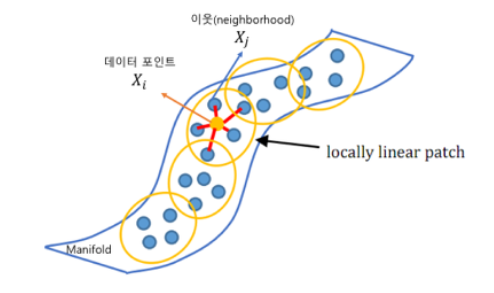

LLE 는 고차원의 공간에서 인접해 있는 데이터들 사이의 선형적 구조를 보존하면서 저차원으로 embedding 한다.  
https://excelsior-cjh.tistory.com/168


### T-SNE ( t-distributed stochastic neighbor embedding)

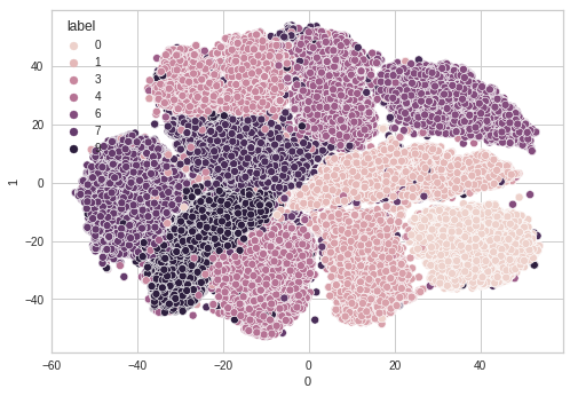

고차원에 분포된 데이터를 저차원으로 축소하며 거리 정보를 보존하되 거리가 가까운 데이터의 정보를 우선하여 보존하기 위해 고안되었다.  
LLE 와 비슷하나 연속적인 확률분포로서 t 분포를 이용하여 가중치를 부여한다.
https://m.blog.naver.com/xorrms78/222112752837

그러나 Neighborhood based training은 고차원 데이터의 경우 같은 유클리디안 메소드를  
사용해도 매니폴드에 따라서 실제로는 가깝지 않을 수도 있다

## AE 종류

### AutoEncoder

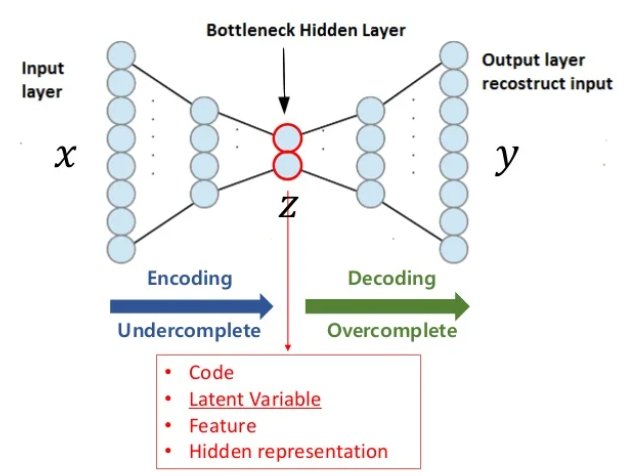

오토 인코더는 입출력이 같은 구조로서 비지도 학습을 할 수 있고,  
인코더는 Manifold를 학습 할 수 있다.

### Stacking AutoEncoder

오토인코더가 처음 나왔을땐 차원축소 기법으로 사용했지만 네트워크 파라미터 초기화에도 많이 쓰였다.

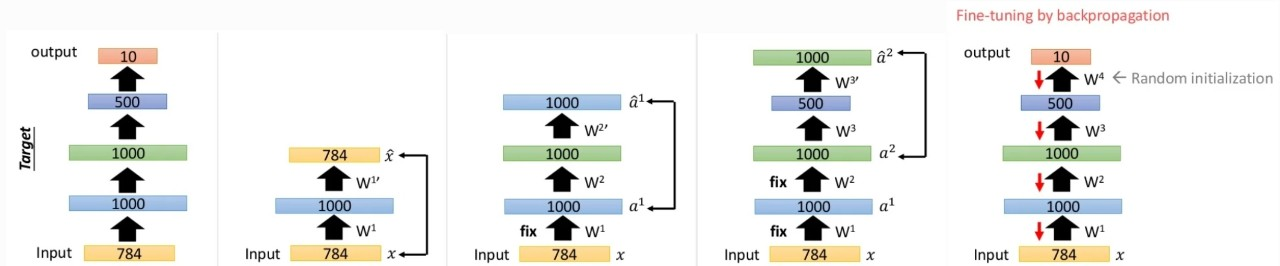

### Denoising AutoEncoder

기존의 오토인코더의 입력값에 noise를 추가해준다.  
노이즈를 어느정도 주더라도 의미적으로는 변하지 않는다.  
결과적으로 기존의 오토인코더보다 좋은 성능을 가진다.

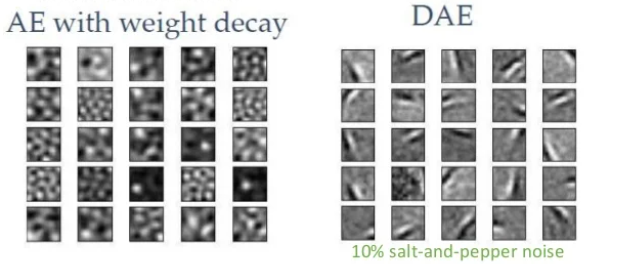

## 실습

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trans = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST('/data',train=True, transform=trans,download=True)
dataloader = DataLoader(dataset=dataset,batch_size=128, shuffle=True)

### AE 정의

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
      super(Encoder,self).__init__()

      self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 10)
        )
      
  def forward(self, x):
        z = self.model(x)
        return z

class Decoder(nn.Module):
  def __init__(self):
      super(Decoder,self).__init__()
  
      self.model = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 28*28),
            nn.Sigmoid()       
        )
  def forward(self, z):
        x = self.model(z)
        return x

In [ ]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=0.001,betas=[0.5,0.999])
MSE = nn.MSELoss().to(device)

for epoch in range(50):
  avg_loss = 0
  for i,(x,_) in enumerate(dataloader):
    x = x.view(-1,28*28).to(device)
    noise_x = add_noise(x)
    z = encoder(noise_x)
    x_r = decoder(z)

    loss = MSE(x_r, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
  print("[Epoch {}] loss:{}".format(epoch, avg_loss/len(dataloader)))

[Epoch 0] loss:0.04534983853779749
[Epoch 1] loss:0.029623805992066987
[Epoch 2] loss:0.02741256783972544
[Epoch 3] loss:0.026238059315250625
[Epoch 4] loss:0.025419866392162562
[Epoch 5] loss:0.024868631040427223
[Epoch 6] loss:0.024383001708622173
[Epoch 7] loss:0.023992019147475136
[Epoch 8] loss:0.023665596300096653
[Epoch 9] loss:0.02340288005117923
[Epoch 10] loss:0.02309239054444248
[Epoch 11] loss:0.022869402419593034
[Epoch 12] loss:0.022642675977843658
[Epoch 13] loss:0.022469168242964663
[Epoch 14] loss:0.022331076044676653
[Epoch 15] loss:0.02222444222711805
[Epoch 16] loss:0.02210879524442941
[Epoch 17] loss:0.022013877377485926
[Epoch 18] loss:0.021943521513136974
[Epoch 19] loss:0.021849799170486454
[Epoch 20] loss:0.021781049279579474
[Epoch 21] loss:0.02170434490100407
[Epoch 22] loss:0.021602070205278996
[Epoch 23] loss:0.021560164815835607
[Epoch 24] loss:0.021464881234998897
[Epoch 25] loss:0.02142479093566632
[Epoch 26] loss:0.021412441455352028
[Epoch 27] loss:0.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save({
    'encoder' : encoder.state_dict(),
    'decoder' : decoder.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/AE_DAE_epoch100_비교_AE')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save({
    'encoder' : encoder.state_dict(),
    'decoder' : decoder.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/AE_DAE_epoch100_비교_DAE')

### model load

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ch1 = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/AE_DAE_epoch100_비교_AE')
ch2 = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/AE_DAE_epoch100_비교_DAE')
encoder.load_state_dict(ch1['encoder'])
decoder.load_state_dict(ch2['decoder'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

### AE

<Figure size 720x720 with 0 Axes>

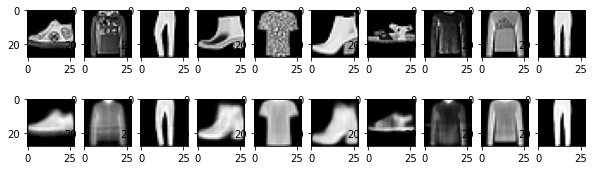

In [ ]:
x = list(dataloader)[0][0][:10]
x = x.view(-1,28*28).to(device)
z = encoder(x)
x_r = decoder(z)
img_x = x.view(10,28,28)
img_r = x_r.view(10,28,28)
imgs = torch.concat([img_x,img_r],dim=0).view(20,28,28)
rows,cols = 2,10
figure = plt.figure(figsize=(10,10))
figure = plt.figure(figsize=(10,3))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(imgs[i-1].cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()

### DAE

<Figure size 720x720 with 0 Axes>

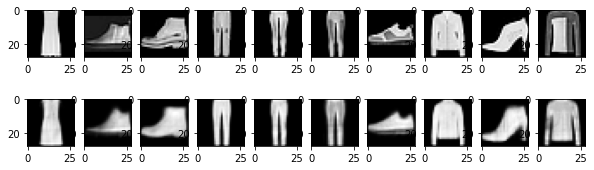

In [ ]:
x = list(dataloader)[0][0][:10]
x = x.view(-1,28*28).to(device)
z = encoder(x)
x_r = decoder(z)
img_x = x.view(10,28,28)
img_r = x_r.view(10,28,28)
imgs = torch.concat([img_x,img_r],dim=0).view(20,28,28)
rows,cols = 2,10
figure = plt.figure(figsize=(10,10))
figure = plt.figure(figsize=(10,3))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(imgs[i-1].cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()